In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, count, when, expr, col, avg, rank, sum, log
from pyspark.sql.types import StringType, IntegerType, DoubleType
from pyspark.sql.window import Window

from pyspark.ml.feature import StandardScaler, VectorAssembler, OneHotEncoder, StringIndexer, Imputer
from pyspark.ml.functions import vector_to_array

import logging

from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import NaiveBayes, LogisticRegression, LinearSVC, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,RegressionEvaluator
from xgboost.spark import SparkXGBClassifier


### Initialize a Spark session and load the dataset into a PySpark DataFrame.

In [2]:
# Initialize Spark Session
spark = SparkSession.builder.appName("ChicagoCrashesDistributedCleaning").getOrCreate()

In [3]:
# import requests

# # Download the file locally
# url = 'https://data.cityofchicago.org/api/views/85ca-t3if/rows.csv'
# response = requests.get(url)

# # Save the file locally
# with open('Traffic_Crashes_-_Crashes.csv', 'wb') as f:
#     f.write(response.content)

# Load the locally saved file into PySpark
crashes = spark.read.csv('Traffic_Crashes_-_Crashes.csv', header=True, inferSchema=True)
print(f"Crashes Data contains: {crashes.count()} rows, {len(crashes.columns)} columns")

# Verify the data
crashes.printSchema()
crashes.show(5)

Crashes Data contains: 895656 rows, 48 columns
root
 |-- CRASH_RECORD_ID: string (nullable = true)
 |-- CRASH_DATE_EST_I: string (nullable = true)
 |-- CRASH_DATE: string (nullable = true)
 |-- POSTED_SPEED_LIMIT: integer (nullable = true)
 |-- TRAFFIC_CONTROL_DEVICE: string (nullable = true)
 |-- DEVICE_CONDITION: string (nullable = true)
 |-- WEATHER_CONDITION: string (nullable = true)
 |-- LIGHTING_CONDITION: string (nullable = true)
 |-- FIRST_CRASH_TYPE: string (nullable = true)
 |-- TRAFFICWAY_TYPE: string (nullable = true)
 |-- LANE_CNT: integer (nullable = true)
 |-- ALIGNMENT: string (nullable = true)
 |-- ROADWAY_SURFACE_COND: string (nullable = true)
 |-- ROAD_DEFECT: string (nullable = true)
 |-- REPORT_TYPE: string (nullable = true)
 |-- CRASH_TYPE: string (nullable = true)
 |-- INTERSECTION_RELATED_I: string (nullable = true)
 |-- NOT_RIGHT_OF_WAY_I: string (nullable = true)
 |-- HIT_AND_RUN_I: string (nullable = true)
 |-- DAMAGE: string (nullable = true)
 |-- DATE_POLIC

# 1. Datatype Conversion and extracting Data

The `CRASH_DATE` column is converted into a datetime format to facilitate filtering by date. We filter the dataset to include only records between June 1, 2023, and December 31, 2023.

In [4]:
# Convert CRASH_DATE to datetime format
# Convert `CRASH_DATE` to datetime format
from pyspark.sql.functions import to_timestamp, col
crashes = crashes.withColumn("CRASH_DATE", to_timestamp(col("CRASH_DATE"), "MM/dd/yyyy hh:mm:ss a"))

# Define the start and end dates for filtering
start_date = "2023-06-01"
end_date = "2023-12-31"

# Filter the dataset based on the date range
filtered_crashes = crashes.filter((col("CRASH_DATE") >= start_date) & (col("CRASH_DATE") <= end_date))

# Show the filtered data count and a few rows for verification
print(f"Filtered Data contains: {filtered_crashes.count()} rows, {len(filtered_crashes.columns)} columns")
filtered_crashes.show(5)

Filtered Data contains: 66218 rows, 48 columns
+--------------------+----------------+-------------------+------------------+----------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------+------------------+--------------------+-----------+-----------+--------------------+----------------------+------------------+-------------+-----------+--------------------+-----------------------+----------------------+---------+----------------+-----------------+------------------+--------------+------------------+---------+-----------+--------------+-----------------+---------+--------------------+--------------+--------------+-----------------------+---------------------------+-----------------------------+----------------------+----------------+----------+-----------------+-----------+------------+-------------+--------------------+
|     CRASH_RECORD_ID|CRASH_DATE_EST_I|         CRASH_DATE|POSTED_SPEED_LIMIT|TRAFFIC_CONTROL_

# 2. RDD Operations for Missing Value Analysis.

Here, we convert the DataFrame to an RDD to perform row-wise analysis of missing values. Using RDD transformations, we compute the number of missing values in each row. Rows with more than 20% missing values are filtered out using RDD filtering operations.


In [5]:
# Get the original columns of the DataFrame
original_cols = filtered_crashes.columns

# Print the initial shape of the DataFrame
print(f"DataFrame shape before dropping: {filtered_crashes.count()} rows, {len(original_cols)} columns")

# 1. Drop columns with more than 30% missing values
# Calculate column threshold (minimum non-null rows required to keep the column)
col_threshold_value = int((1 - 0.3) * filtered_crashes.count())

# Filter columns based on the threshold
columns_to_keep = [
    c for c in original_cols if filtered_crashes.select(count(when(col(c).isNotNull(), c))).first()[0] >= col_threshold_value
]
filtered_crashes = filtered_crashes.select(*columns_to_keep)
cleaned_cols = filtered_crashes.columns
print(f"DataFrame shape after dropping some columns: {filtered_crashes.count()} rows, {len(cleaned_cols)} columns")

dropped_columns = set(original_cols) - set(cleaned_cols)
print(f"Dropping Columns are: {dropped_columns}")

DataFrame shape before dropping: 66218 rows, 48 columns
DataFrame shape after dropping some columns: 66218 rows, 37 columns
Dropping Columns are: {'WORKERS_PRESENT_I', 'NOT_RIGHT_OF_WAY_I', 'DOORING_I', 'STATEMENTS_TAKEN_I', 'LANE_CNT', 'HIT_AND_RUN_I', 'INTERSECTION_RELATED_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'CRASH_DATE_EST_I', 'PHOTOS_TAKEN_I'}


In [8]:
# Calculate the row threshold
row_threshold_value = int((1 - 0.2) * len(columns_to_keep))

# Drop rows with fewer than the threshold of non-null values
filtered_crashes = filtered_crashes.na.drop(thresh=row_threshold_value, subset=columns_to_keep)

print(f"DataFrame shape after dropping: {filtered_crashes.count()} rows, {len(filtered_crashes.columns)} columns")

DataFrame shape after dropping: 66212 rows, 37 columns


# 3. Handling Missing Values

In this section, missing values in categorical and numerical columns are handled.For categorical columns, missing values are replaced with the mode (most frequent value). For numerical columns, missing values are replaced with the median to account for potential outliers.

In [9]:
filtered_crashes.printSchema()

root
 |-- CRASH_RECORD_ID: string (nullable = true)
 |-- CRASH_DATE: timestamp (nullable = true)
 |-- POSTED_SPEED_LIMIT: integer (nullable = true)
 |-- TRAFFIC_CONTROL_DEVICE: string (nullable = true)
 |-- DEVICE_CONDITION: string (nullable = true)
 |-- WEATHER_CONDITION: string (nullable = true)
 |-- LIGHTING_CONDITION: string (nullable = true)
 |-- FIRST_CRASH_TYPE: string (nullable = true)
 |-- TRAFFICWAY_TYPE: string (nullable = true)
 |-- ALIGNMENT: string (nullable = true)
 |-- ROADWAY_SURFACE_COND: string (nullable = true)
 |-- ROAD_DEFECT: string (nullable = true)
 |-- REPORT_TYPE: string (nullable = true)
 |-- CRASH_TYPE: string (nullable = true)
 |-- DAMAGE: string (nullable = true)
 |-- DATE_POLICE_NOTIFIED: string (nullable = true)
 |-- PRIM_CONTRIBUTORY_CAUSE: string (nullable = true)
 |-- SEC_CONTRIBUTORY_CAUSE: string (nullable = true)
 |-- STREET_NO: integer (nullable = true)
 |-- STREET_DIRECTION: string (nullable = true)
 |-- STREET_NAME: string (nullable = true)
 |-

In [11]:
# ### 2.1: Categorical Columns Missing Values

# Identify categorical columns
cat_cols = [field.name for field in filtered_crashes.schema.fields if isinstance(field.dataType, StringType)]
print("Categorical columns:", cat_cols)

# Print null counts for categorical columns
print("Null counts for categorical columns:")
filtered_crashes.select([count(when(col(c).isNull(), c)).alias(c) for c in cat_cols]).show()

# Fill missing values in categorical columns with the mode (most frequent value)
cat_cols = ['REPORT_TYPE','MOST_SEVERE_INJURY']
for col_name in cat_cols:
    # Calculate the mode for the column
    mode_value = (
        filtered_crashes.groupBy(col_name).count().orderBy("count", ascending=False).first()[0]
    )
    # Fill missing values with the mode
    filtered_crashes = filtered_crashes.fillna({col_name: mode_value})
    print(f"Column: {col_name} - Mode Value: {mode_value}")

Categorical columns: ['CRASH_RECORD_ID', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'DAMAGE', 'DATE_POLICE_NOTIFIED', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_DIRECTION', 'STREET_NAME', 'MOST_SEVERE_INJURY', 'LOCATION']
Null counts for categorical columns:
+---------------+----------------------+----------------+-----------------+------------------+----------------+---------------+---------+--------------------+-----------+-----------+----------+------+--------------------+-----------------------+----------------------+----------------+-----------+------------------+--------+
|CRASH_RECORD_ID|TRAFFIC_CONTROL_DEVICE|DEVICE_CONDITION|WEATHER_CONDITION|LIGHTING_CONDITION|FIRST_CRASH_TYPE|TRAFFICWAY_TYPE|ALIGNMENT|ROADWAY_SURFACE_COND|ROAD_DEFECT|REPORT_TYPE|CRASH_TYPE|DAMAGE|DATE_POLICE_NOTIFIED|PRIM_CONTR

In [13]:
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import count, when, col

# Identify all numerical columns
all_num_cols = [field.name for field in filtered_crashes.schema.fields if isinstance(field.dataType, (IntegerType, DoubleType))]
print("All numerical columns:", all_num_cols)

# Identify numerical columns with missing values
null_counts = filtered_crashes.select([count(when(col(c).isNull(), c)).alias(c) for c in all_num_cols]).toPandas()
num_cols_with_nulls = null_counts.loc[:, (null_counts != 0).any()].columns.tolist()
print("Numerical columns with missing values:", num_cols_with_nulls)

# Use Imputer to fill missing values with the median
if num_cols_with_nulls:
    imputer = Imputer(inputCols=num_cols_with_nulls, outputCols=num_cols_with_nulls).setStrategy("median")
    filtered_crashes = imputer.fit(filtered_crashes).transform(filtered_crashes)

# Verify results
print("Missing values after imputation:")
filtered_crashes.select([count(when(col(c).isNull(), c)).alias(c) for c in num_cols_with_nulls]).show()


All numerical columns: ['POSTED_SPEED_LIMIT', 'STREET_NO', 'BEAT_OF_OCCURRENCE', 'NUM_UNITS', 'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE']
Numerical columns with missing values: ['INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'LATITUDE', 'LONGITUDE']
Missing values after imputation:
+--------------+--------------+-----------------------+---------------------------+-----------------------------+----------------------+----------------+--------+---------+
|INJURIES_TOTAL|INJURIES_FATAL|INJURIES_INCAPACITATING|INJURIES_NON_INCAPACITATING|INJURIES_REPORTED_NOT_EVIDENT|INJURIES_NO_INDICATION|INJURIES_UNKNOWN|LATITUDE|LONGITUDE|
+--------------+--------------+----------

#4. Standardizing Numerical Columns in PySpark

This PySpark implementation standardizes numerical columns in a DataFrame using pyspark.ml.feature.StandardScaler. The process ensures that all numerical columns have a mean of 0 and a standard deviation of 1. This is a common preprocessing step in machine learning pipelines to improve model performance and stability.

In [14]:


# ### Step 1: Identify Numerical Columns
# Identify all numerical columns from the schema (IntegerType and DoubleType).
num_cols = [field.name for field in filtered_crashes.schema.fields if isinstance(field.dataType, (IntegerType, DoubleType))]
print("All numerical columns:", num_cols)

# ### Step 2: Assemble Numerical Columns into a Feature Vector
# The `VectorAssembler` combines all numerical columns into a single feature vector
# required for the `StandardScaler`.
assembler = VectorAssembler(inputCols=num_cols, outputCol="features_vector")
filtered_crashes_vectorized = assembler.transform(filtered_crashes)

# ### Step 3: Apply StandardScaler to the Feature Vector
# The `StandardScaler` scales numerical columns to have mean 0 and standard deviation 1.
scaler = StandardScaler(inputCol="features_vector", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(filtered_crashes_vectorized)
filtered_crashes_scaled = scaler_model.transform(filtered_crashes_vectorized)

# ### Step 4: Extract Scaled Values into Individual Columns
# Convert the scaled features vector to an array for easy extraction of individual columns.
filtered_crashes_scaled = filtered_crashes_scaled.withColumn("scaled_array", vector_to_array(col("scaled_features")))

# Extract individual scaled columns with a `scaled_` prefix
scaled_columns = [f"scaled_{col_name}" for col_name in num_cols]
for i, col_name in enumerate(num_cols):
    filtered_crashes_scaled = filtered_crashes_scaled.withColumn(scaled_columns[i], col("scaled_array")[i])

# ### Step 5: Clean Up Intermediate Columns
# Drop intermediate columns (`features_vector`, `scaled_features`, and `scaled_array`) for a cleaner final DataFrame.
filtered_crashes_scaled = filtered_crashes_scaled.drop("features_vector", "scaled_features", "scaled_array")

# ### Step 6: Display Final Results
print("Final DataFrame after handling missing values and standardizing numerical columns:")
print(f"DataFrame contains {filtered_crashes_scaled.count()} rows and {len(filtered_crashes_scaled.columns)} columns.")

# Display summary statistics for scaled columns
for col_name in scaled_columns:
    print(f"Summary statistics for {col_name}:")
    filtered_crashes_scaled.select(col_name).describe().show()


All numerical columns: ['POSTED_SPEED_LIMIT', 'STREET_NO', 'BEAT_OF_OCCURRENCE', 'NUM_UNITS', 'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE']
Final DataFrame after handling missing values and standardizing numerical columns:
DataFrame contains 66212 rows and 53 columns.
Summary statistics for scaled_POSTED_SPEED_LIMIT:
+-------+-------------------------+
|summary|scaled_POSTED_SPEED_LIMIT|
+-------+-------------------------+
|  count|                    66212|
|   mean|     1.734397344190590...|
| stddev|       0.9999999999999996|
|    min|       -5.151340343790245|
|    max|        7.437995826534728|
+-------+-------------------------+

Summary statistics for scaled_STREET_NO:
+-------+--------------------+
|summary|    scaled_STREET_NO|
+-------+--------------------+
|  count|           

# 5. Dealing with Categorical Values and Inconsistencies - Mapping

Mapping categorical values helps simplify data by consolidating similar or rare categories into broader, meaningful groups. This process reduces the dimensionality of categorical columns, enhances interpretability, and improves the efficiency of downstream analysis. By grouping related values (e.g., consolidating traffic control types or weather conditions), we ensure a cleaner dataset that focuses on key patterns while minimizing noise. This technique is especially useful when dealing with columns containing too many unique or inconsistent values.

In [15]:

# Define the mapping for `TRAFFIC_CONTROL_DEVICE`
traffic_control_mapping = {
    'TRAFFIC SIGNAL': 'SIGNAL',
    'FLASHING CONTROL SIGNAL': 'SIGNAL',
    'RAILROAD CROSSING GATE': 'SIGNAL',
    'STOP SIGN/FLASHER': 'STOP SIGN',
    'STOP SIGN': 'STOP SIGN',
    'YIELD': 'YIELD',
    'UNKNOWN': 'OTHER',
    'OTHER REG. SIGN': 'OTHER',
    'WARNING SIGN': 'WARNING SIGN',
    'OTHER WARNING SIGN': 'WARNING SIGN',
    'OTHER SIGN': 'WARNING SIGN',
    'BICYCLE CROSSING SIGN': 'CROSSING SIGN',
    'PEDESTRIAN CROSSING SIGN': 'CROSSING SIGN',
    'RR CROSSING SIGN': 'CROSSING SIGN',
    'OTHER RAILROAD CROSSING': 'CROSSING SIGN',
    'POLICE/FLAGMAN': 'POLICE',
    'SCHOOL ZONE': 'SCHOOL ZONE',
    'NO CONTROLS': 'NO CONTROLS',
    'NO PASSING': 'OTHER',
}

# Replace categories in `TRAFFIC_CONTROL_DEVICE` using the mapping
mapped_column = when(col("TRAFFIC_CONTROL_DEVICE").isNull(), "OTHER")  # Handle null values first
for key, value in traffic_control_mapping.items():
    mapped_column = mapped_column.when(col("TRAFFIC_CONTROL_DEVICE") == key, value)

# Apply the mapping to create a new column
filtered_crashes = filtered_crashes.withColumn("TRAFFIC_CONTROL_DEVICE", mapped_column)

# Group by `TRAFFIC_CONTROL_DEVICE` and count occurrences
merged_counts = (
    filtered_crashes.groupBy("TRAFFIC_CONTROL_DEVICE")
    .count()
    .orderBy(col("count").desc())
)

# Display the mapped counts
merged_counts.show(truncate=False)


+----------------------+-----+
|TRAFFIC_CONTROL_DEVICE|count|
+----------------------+-----+
|NO CONTROLS           |35719|
|SIGNAL                |18510|
|STOP SIGN             |6515 |
|OTHER                 |4573 |
|NULL                  |567  |
|YIELD                 |129  |
|CROSSING SIGN         |113  |
|WARNING SIGN          |46   |
|POLICE                |22   |
|SCHOOL ZONE           |18   |
+----------------------+-----+



In [16]:
# Define the mapping for `WEATHER_CONDITION`
weather_mapping = {
    'CLEAR': 'CLEAR',
    'RAIN': 'RAIN',
    'FREEZING RAIN/DRIZZLE': 'RAIN',
    'CLOUDY/OVERCAST': 'CLOUDY/OVERCAST',
    'SNOW': 'SNOW',
    'SLEET/HAIL': 'SNOW',
    'BLOWING SNOW': 'SNOW',
    'FOG/SMOKE/HAZE': 'FOG/SMOKE/HAZE',
    'UNKNOWN': 'OTHER',
    'OTHER': 'OTHER',
    'SEVERE CROSS WIND GATE': 'OTHER',
    'BLOWING SAND, SOIL, DIRT': 'OTHER',
}

# Replace values in `WEATHER_CONDITION` using the mapping
weather_column = when(col("WEATHER_CONDITION").isNull(), "OTHER")  # Handle null values first
for key, value in weather_mapping.items():
    weather_column = weather_column.when(col("WEATHER_CONDITION") == key, value)

# Apply the mapping to create a new column
filtered_crashes = filtered_crashes.withColumn("WEATHER_CONDITION", weather_column)

# Group by `WEATHER_CONDITION` and count occurrences
weather_counts = (
    filtered_crashes.groupBy("WEATHER_CONDITION")
    .count()
    .orderBy(col("count").desc())
)

# Display the mapped counts
weather_counts.show(truncate=False)


+-----------------+-----+
|WEATHER_CONDITION|count|
+-----------------+-----+
|CLEAR            |51197|
|RAIN             |7014 |
|OTHER            |5647 |
|CLOUDY/OVERCAST  |1810 |
|SNOW             |370  |
|FOG/SMOKE/HAZE   |174  |
+-----------------+-----+



In [17]:
# Define the mapping for `PRIM_CONTRIBUTORY_CAUSE`
primary_cause_mapping = {
    'UNABLE TO DETERMINE': 'UNKNOWN',
    'FAILING TO YIELD RIGHT-OF-WAY': 'YIELDING ISSUES',
    'FOLLOWING TOO CLOSELY': 'FOLLOWING TOO CLOSELY',
    'IMPROPER OVERTAKING/PASSING': 'OVERTAKING ISSUES',
    'NOT APPLICABLE': 'NOT APPLICABLE',
    'FAILING TO REDUCE SPEED TO AVOID CRASH': 'SPEEDING',
    'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE': 'DRIVING SKILLS',
    'IMPROPER TURNING/NO SIGNAL': 'TURNING ISSUES',
    'IMPROPER BACKING': 'BACKING ISSUES',
    'IMPROPER LANE USAGE': 'LANE USAGE',
    'DISREGARDING TRAFFIC SIGNALS': 'SIGNAL ISSUES',
    'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER': 'DRIVING SKILLS',
    'DISREGARDING STOP SIGN': 'SIGNAL ISSUES',
    'WEATHER': 'WEATHER',
    'DRIVING ON WRONG SIDE/WRONG WAY': 'DRIVING SKILLS',
    'DISTRACTION - FROM INSIDE VEHICLE': 'DISTRACTION',
    'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)': 'OBSTRUCTED VIEW',
    'EQUIPMENT - VEHICLE CONDITION': 'VEHICLE CONDITION',
    'PHYSICAL CONDITION OF DRIVER': 'PHYSICAL CONDITION',
    'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)': 'UNDER INFLUENCE',
    'DISTRACTION - FROM OUTSIDE VEHICLE': 'DISTRACTION',
    'DISREGARDING OTHER TRAFFIC SIGNS': 'SIGNAL ISSUES',
    'ROAD CONSTRUCTION/MAINTENANCE': 'ROAD CONDITIONS',
    'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST': 'EVASIVE ACTION',
    'CELL PHONE USE OTHER THAN TEXTING': 'DISTRACTION',
    'TURNING RIGHT ON RED': 'TURNING ISSUES',
    'ROAD ENGINEERING/SURFACE/MARKING DEFECTS': 'ROAD CONDITIONS',
    'ANIMAL': 'ANIMALS',
    'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)': 'UNDER INFLUENCE',
    'RELATED TO BUS STOP': 'BUS STOP ISSUES',
    'DISREGARDING ROAD MARKINGS': 'SIGNAL ISSUES',
    'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)': 'DISTRACTION',
    'OBSTRUCTED CROSSWALKS': 'OBSTRUCTED VIEW',
    'TEXTING': 'DISTRACTION',
    'DISREGARDING YIELD SIGN': 'SIGNAL ISSUES',
    'PASSING STOPPED SCHOOL BUS': 'SIGNAL ISSUES',
    'BICYCLE ADVANCING LEGALLY ON RED LIGHT': 'SIGNAL ISSUES',
    'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT': 'SIGNAL ISSUES',
}

# Replace values in `PRIM_CONTRIBUTORY_CAUSE` using the mapping
cause_column = when(col("PRIM_CONTRIBUTORY_CAUSE").isNull(), "UNKNOWN")  # Handle null values first
for key, value in primary_cause_mapping.items():
    cause_column = cause_column.when(col("PRIM_CONTRIBUTORY_CAUSE") == key, value)

# Apply the mapping to create a new column
filtered_crashes = filtered_crashes.withColumn("PRIM_CONTRIBUTORY_CAUSE", cause_column)

# Group by `PRIM_CONTRIBUTORY_CAUSE` and count occurrences
cause_counts = (
    filtered_crashes.groupBy("PRIM_CONTRIBUTORY_CAUSE")
    .count()
    .orderBy(col("count").desc())
)

# Display the mapped counts
cause_counts.show(truncate=False)


+-----------------------+-----+
|PRIM_CONTRIBUTORY_CAUSE|count|
+-----------------------+-----+
|UNKNOWN                |27733|
|YIELDING ISSUES        |7578 |
|FOLLOWING TOO CLOSELY  |5469 |
|DRIVING SKILLS         |3878 |
|OVERTAKING ISSUES      |3650 |
|NOT APPLICABLE         |3623 |
|SPEEDING               |2683 |
|TURNING ISSUES         |2371 |
|SIGNAL ISSUES          |2186 |
|BACKING ISSUES         |2089 |
|LANE USAGE             |1948 |
|DISTRACTION            |759  |
|WEATHER                |505  |
|OBSTRUCTED VIEW        |396  |
|VEHICLE CONDITION      |359  |
|PHYSICAL CONDITION     |315  |
|UNDER INFLUENCE        |276  |
|ROAD CONDITIONS        |178  |
|EVASIVE ACTION         |100  |
|ANIMALS                |59   |
+-----------------------+-----+
only showing top 20 rows



# 6. Windowing Operations for Rolling Metrics and Ranking
Windowing operations allow the calculation of metrics like rolling averages and rankings within defined partitions of the data. In this example, we use the CRASH_HOUR column to group rows and calculate the rolling average of POSTED_SPEED_LIMIT and rank crashes based on CRASH_DATE within each hour. This technique is useful for understanding trends and patterns over time or across categorical segments of the data. The results provide deeper insights into speed variations and event chronology.

In [18]:


# Step 1: Define a Window Specification
# Partition the data by a categorical column (e.g., 'TRAFFIC_CONTROL_DEVICE')
# and order rows within each partition by a numerical column (e.g., 'CRASH_DATE').
window_spec = Window.partitionBy("CRASH_HOUR").orderBy(col("CRASH_DATE"))

# Step 2: Calculate Rolling Average
# Add a new column that computes the rolling average of 'POSTED_SPEED_LIMIT' within the window
filtered_crashes = filtered_crashes.withColumn(
    "rolling_avg_speed", avg(col("POSTED_SPEED_LIMIT")).over(window_spec)
)

# Step 3: Calculate Rank
# Add a column for ranking within each partition based on 'CRASH_DATE'
filtered_crashes = filtered_crashes.withColumn(
    "rank", rank().over(window_spec)
)

# Step 4: Display the Results
filtered_crashes.select(
    "TRAFFIC_CONTROL_DEVICE", "CRASH_DATE", "POSTED_SPEED_LIMIT", "rolling_avg_speed", "rank"
).show(truncate=False)


+----------------------+-------------------+------------------+------------------+----+
|TRAFFIC_CONTROL_DEVICE|CRASH_DATE         |POSTED_SPEED_LIMIT|rolling_avg_speed |rank|
+----------------------+-------------------+------------------+------------------+----+
|SIGNAL                |2023-06-01 00:30:00|30                |30.0              |1   |
|NO CONTROLS           |2023-06-01 00:43:00|15                |22.5              |2   |
|NO CONTROLS           |2023-06-02 00:10:00|30                |27.5              |3   |
|NO CONTROLS           |2023-06-02 00:10:00|35                |27.5              |3   |
|NO CONTROLS           |2023-06-02 00:45:00|30                |28.0              |5   |
|SIGNAL                |2023-06-03 00:00:00|35                |29.166666666666668|6   |
|NO CONTROLS           |2023-06-03 00:01:00|10                |26.428571428571427|7   |
|NO CONTROLS           |2023-06-03 00:03:00|30                |26.875            |8   |
|NO CONTROLS           |2023-06-

# 7. Removing Redundant Columns/Rows

In this section, unnecessary columns such as LOCATION, SEC_CONTRIBUTORY_CAUSE, and others were removed to simplify the dataset. These columns were either irrelevant for analysis, contained duplicate information, or added unnecessary complexity. By reducing the dataset to 31 columns, we improved its focus and efficiency, ensuring only meaningful features remain for further modeling and analysis. This step is crucial for optimizing performance and maintaining data quality.

In [19]:
# Step 1: Define the list of redundant columns
redundant_cols = ['CRASH_RECORD_ID', 'LOCATION', 'CRASH_DATE', 'SEC_CONTRIBUTORY_CAUSE', 'DATE_POLICE_NOTIFIED', 'STREET_DIRECTION', 'STREET_NAME', 'STREET_NO']

# Step 2: Drop the redundant columns
filtered_crashes = filtered_crashes.drop(*redundant_cols)
filtered_crashes = filtered_crashes.dropna()

# Step 3: Display the updated schema and DataFrame shape
print(f"Updated DataFrame contains {filtered_crashes.count()} rows and {len(filtered_crashes.columns)} columns.")
filtered_crashes.printSchema()

Updated DataFrame contains 65645 rows and 31 columns.
root
 |-- POSTED_SPEED_LIMIT: integer (nullable = true)
 |-- TRAFFIC_CONTROL_DEVICE: string (nullable = true)
 |-- DEVICE_CONDITION: string (nullable = true)
 |-- WEATHER_CONDITION: string (nullable = true)
 |-- LIGHTING_CONDITION: string (nullable = true)
 |-- FIRST_CRASH_TYPE: string (nullable = true)
 |-- TRAFFICWAY_TYPE: string (nullable = true)
 |-- ALIGNMENT: string (nullable = true)
 |-- ROADWAY_SURFACE_COND: string (nullable = true)
 |-- ROAD_DEFECT: string (nullable = true)
 |-- REPORT_TYPE: string (nullable = false)
 |-- CRASH_TYPE: string (nullable = true)
 |-- DAMAGE: string (nullable = true)
 |-- PRIM_CONTRIBUTORY_CAUSE: string (nullable = true)
 |-- BEAT_OF_OCCURRENCE: integer (nullable = true)
 |-- NUM_UNITS: integer (nullable = true)
 |-- MOST_SEVERE_INJURY: string (nullable = false)
 |-- INJURIES_TOTAL: integer (nullable = true)
 |-- INJURIES_FATAL: integer (nullable = true)
 |-- INJURIES_INCAPACITATING: integer (nu

In [20]:
# Calculate the number of null values in each column
null_counts = filtered_crashes.select(
    *[sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in filtered_crashes.columns]
)

# Show the result
null_counts.show()

+------------------+----------------------+----------------+-----------------+------------------+----------------+---------------+---------+--------------------+-----------+-----------+----------+------+-----------------------+------------------+---------+------------------+--------------+--------------+-----------------------+---------------------------+-----------------------------+----------------------+----------------+----------+-----------------+-----------+--------+---------+-----------------+----+
|POSTED_SPEED_LIMIT|TRAFFIC_CONTROL_DEVICE|DEVICE_CONDITION|WEATHER_CONDITION|LIGHTING_CONDITION|FIRST_CRASH_TYPE|TRAFFICWAY_TYPE|ALIGNMENT|ROADWAY_SURFACE_COND|ROAD_DEFECT|REPORT_TYPE|CRASH_TYPE|DAMAGE|PRIM_CONTRIBUTORY_CAUSE|BEAT_OF_OCCURRENCE|NUM_UNITS|MOST_SEVERE_INJURY|INJURIES_TOTAL|INJURIES_FATAL|INJURIES_INCAPACITATING|INJURIES_NON_INCAPACITATING|INJURIES_REPORTED_NOT_EVIDENT|INJURIES_NO_INDICATION|INJURIES_UNKNOWN|CRASH_HOUR|CRASH_DAY_OF_WEEK|CRASH_MONTH|LATITUDE|LONGITUDE|ro

# 8. Encoding Data

Encoding transforms categorical data into numerical formats, making it usable for machine learning models that operate on numerical inputs. It ensures the relationships or distinctions between categories are preserved. For example, ordinal encoding captures the order of categories, while nominal encoding treats all categories as equally distinct. This step is crucial for accurate model training and predictions.

In [21]:
# Categorical Encoding

# Identify categorical columns
cat_cols = [field.name for field in filtered_crashes.schema.fields if isinstance(field.dataType, StringType)]
print("Categorical Columns:", cat_cols)


Categorical Columns: ['TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE', 'MOST_SEVERE_INJURY']


## Ordinal Encoding

Ordinal encoding was applied to columns with a natural order, such as LIGHTING_CONDITION, MOST_SEVERE_INJURY, and DAMAGE. Each category was mapped to an integer value based on its rank or severity. This process preserves the ordinal relationships between categories, enabling models to interpret the increasing or decreasing trend in values. For example, DAYLIGHT was encoded as 1 and DARKNESS as 3, reflecting their relative significance.

In [22]:
# 8.1 Ordinal Encoding

# Define the ordinal mappings for each column
lighting_condition_mapping = {
    'DAYLIGHT': 1,
    'DARKNESS, LIGHTED ROAD': 2,
    'DARKNESS': 3,
    'DUSK': 4,
    'DAWN': 5,
    'UNKNOWN': 6
}

most_severe_injury_mapping = {
    'NO INDICATION OF INJURY': 1,
    'NONINCAPACITATING INJURY': 2,
    'REPORTED, NOT EVIDENT': 3,
    'INCAPACITATING INJURY': 4,
    'FATAL': 5
}

report_type_mapping = {
    'NOT ON SCENE (DESK REPORT)': 1,
    'ON SCENE': 2
}

crash_type_mapping = {
    'NO INJURY / DRIVE AWAY': 0,
    'INJURY AND / OR TOW DUE TO CRASH': 1
}

hit_and_run_mapping = {
    'Y': 1,
    'N': 0
}

damage_mapping = {
    'OVER $1,500': 3,
    '$501 - $1,500': 2,
    '$500 OR LESS': 1
}

In [23]:
# Helper function to apply mapping
def apply_mapping(df, col_name, mapping):
    mapping_expr = when(col(col_name).isNull(), None)
    for key, value in mapping.items():
        mapping_expr = mapping_expr.when(col(col_name) == key, value)
    return df.withColumn(col_name, mapping_expr)

In [24]:
# Apply the mappings to the respective columns
filtered_crashes = apply_mapping(filtered_crashes, "LIGHTING_CONDITION", lighting_condition_mapping)
filtered_crashes = apply_mapping(filtered_crashes, "MOST_SEVERE_INJURY", most_severe_injury_mapping)
filtered_crashes = apply_mapping(filtered_crashes, "REPORT_TYPE", report_type_mapping)
filtered_crashes = apply_mapping(filtered_crashes, "CRASH_TYPE", crash_type_mapping)
filtered_crashes = apply_mapping(filtered_crashes, "DAMAGE", damage_mapping)

# Show the updated DataFrame
filtered_crashes.select(
    "LIGHTING_CONDITION", "MOST_SEVERE_INJURY", "REPORT_TYPE", "CRASH_TYPE", "DAMAGE"
).show()

+------------------+------------------+-----------+----------+------+
|LIGHTING_CONDITION|MOST_SEVERE_INJURY|REPORT_TYPE|CRASH_TYPE|DAMAGE|
+------------------+------------------+-----------+----------+------+
|                 3|                 1|          1|         0|     2|
|                 2|                 1|          2|         1|     3|
|                 2|                 1|          2|         1|     3|
|                 3|                 1|          1|         0|     3|
|                 6|                 1|          1|         0|     3|
|                 2|                 5|          2|         1|     3|
|                 2|                 1|          2|         0|     3|
|                 4|                 1|          2|         1|     3|
|                 2|                 1|          2|         1|     3|
|                 2|                 1|          2|         0|     3|
|                 3|                 1|          2|         0|     2|
|                 2|

## Nominal Encoding

For categorical columns without an inherent order, such as TRAFFIC_CONTROL_DEVICE and WEATHER_CONDITION, one-hot encoding was applied. This technique created binary vector representations for each category, allowing models to process these columns without assuming any relationship between categories. By transforming nominal data into vectors, we ensured compatibility with machine learning algorithms while avoiding misleading assumptions about category relationships.

In [25]:

# Define columns for nominal encoding**
columns_for_nominal_encoding = [
    'TRAFFIC_CONTROL_DEVICE',
    'DEVICE_CONDITION',
    'WEATHER_CONDITION',
    'FIRST_CRASH_TYPE',
    'TRAFFICWAY_TYPE',
    'ALIGNMENT',
    'ROADWAY_SURFACE_COND',
    'ROAD_DEFECT',
    'PRIM_CONTRIBUTORY_CAUSE'
]

# Index and One-Hot Encode each column**
# Initialize empty DataFrame to append processed columns
for col_name in columns_for_nominal_encoding:
    # StringIndexer converts string categories into numerical indices
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index")
    filtered_crashes = indexer.fit(filtered_crashes).transform(filtered_crashes)

    # OneHotEncoder converts indices into one-hot encoded vectors
    encoder = OneHotEncoder(inputCol=f"{col_name}_index", outputCol=f"{col_name}_encoded")
    filtered_crashes = encoder.fit(filtered_crashes).transform(filtered_crashes)

# Drop original and intermediate columns (optional)**
# Drop the original categorical columns and index columns, keeping only the encoded versions
columns_to_drop = columns_for_nominal_encoding + [f"{col}_index" for col in columns_for_nominal_encoding]
filtered_crashes = filtered_crashes.drop(*columns_to_drop)

# Display the schema to verify encoded columns**
filtered_crashes.printSchema()

# Show some rows for verification**
filtered_crashes.show(5, truncate=False)

root
 |-- POSTED_SPEED_LIMIT: integer (nullable = true)
 |-- LIGHTING_CONDITION: integer (nullable = true)
 |-- REPORT_TYPE: integer (nullable = true)
 |-- CRASH_TYPE: integer (nullable = true)
 |-- DAMAGE: integer (nullable = true)
 |-- BEAT_OF_OCCURRENCE: integer (nullable = true)
 |-- NUM_UNITS: integer (nullable = true)
 |-- MOST_SEVERE_INJURY: integer (nullable = true)
 |-- INJURIES_TOTAL: integer (nullable = true)
 |-- INJURIES_FATAL: integer (nullable = true)
 |-- INJURIES_INCAPACITATING: integer (nullable = true)
 |-- INJURIES_NON_INCAPACITATING: integer (nullable = true)
 |-- INJURIES_REPORTED_NOT_EVIDENT: integer (nullable = true)
 |-- INJURIES_NO_INDICATION: integer (nullable = true)
 |-- INJURIES_UNKNOWN: integer (nullable = true)
 |-- CRASH_HOUR: integer (nullable = true)
 |-- CRASH_DAY_OF_WEEK: integer (nullable = true)
 |-- CRASH_MONTH: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- rolling_avg_speed: doubl

In [26]:
print(f"Cleaned DataFrame contains {filtered_crashes.count()} rows and {len(filtered_crashes.columns)} columns.")


Cleaned DataFrame contains 65645 rows and 31 columns.


# Saving the Cleaned/ Encoded Data

In [28]:
# Save the DataFrame to a Parquet file
encoded_data_path = "encoded_data.parquet"
# filtered_crashes.write.parquet(encoded_data_path, mode="overwrite")

In [29]:
# Load the encoded data from the Parquet file
loaded_encoded_data = spark.read.parquet(encoded_data_path)

# Verify the loaded DataFrame
print(f"Loaded DataFrame contains {loaded_encoded_data.count()} rows and {len(loaded_encoded_data.columns)} columns.")
loaded_encoded_data.printSchema()

Loaded DataFrame contains 65645 rows and 31 columns.
root
 |-- POSTED_SPEED_LIMIT: integer (nullable = true)
 |-- LIGHTING_CONDITION: integer (nullable = true)
 |-- REPORT_TYPE: integer (nullable = true)
 |-- CRASH_TYPE: integer (nullable = true)
 |-- DAMAGE: integer (nullable = true)
 |-- BEAT_OF_OCCURRENCE: integer (nullable = true)
 |-- NUM_UNITS: integer (nullable = true)
 |-- MOST_SEVERE_INJURY: integer (nullable = true)
 |-- INJURIES_TOTAL: integer (nullable = true)
 |-- INJURIES_FATAL: integer (nullable = true)
 |-- INJURIES_INCAPACITATING: integer (nullable = true)
 |-- INJURIES_NON_INCAPACITATING: integer (nullable = true)
 |-- INJURIES_REPORTED_NOT_EVIDENT: integer (nullable = true)
 |-- INJURIES_NO_INDICATION: integer (nullable = true)
 |-- INJURIES_UNKNOWN: integer (nullable = true)
 |-- CRASH_HOUR: integer (nullable = true)
 |-- CRASH_DAY_OF_WEEK: integer (nullable = true)
 |-- CRASH_MONTH: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: d

In [30]:
spark.stop()

print("Spark session ended.")

Spark session ended.


# Algorithms

In [2]:
# Initialize Spark Session
spark = SparkSession.builder.appName("ModelTraining").getOrCreate()

In [3]:
filtered_crashes = spark.read.parquet("encoded_data.parquet")
# Display the count and verify
print(f"Dataset contains {filtered_crashes.count()} rows and {len(filtered_crashes.columns)} columns.")

Dataset contains 65645 rows and 31 columns.


## Feature Engineering

Feature engineering in PySpark involves transforming raw data into a structured format suitable for machine learning. Key steps include handling missing values with PySpark's Imputer, encoding categorical variables using StringIndexer or OneHotEncoder, and normalizing numerical features with StandardScaler. The features are then combined into a single vector using VectorAssembler, and the target variable (label) is prepared for modeling. This ensures the dataset is clean and compatible with PySpark ML pipelines.

In [4]:
# Combine feature columns into a single vector
feature_columns = [col for col in filtered_crashes.columns if col not in ["CRASH_TYPE", "label_column"]]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(filtered_crashes)

# Prepare the final dataset
final_data = data.select("features", col("CRASH_TYPE").alias("label"))
final_data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(114,[0,1,2,3,4,5...|    0|
|(114,[0,1,2,3,4,5...|    1|
|(114,[0,1,2,3,4,5...|    1|
|(114,[0,1,2,3,4,5...|    1|
|(114,[0,1,2,3,4,5...|    0|
+--------------------+-----+
only showing top 5 rows



In [5]:
# Split data into train, validation, and test sets
train_data, validation_data, test_data = final_data.randomSplit([0.7, 0.15, 0.15], seed=69)

# Print counts for each split
print(f"Training Data Count: {train_data.count()}")
print(f"Validation Data Count: {validation_data.count()}")
print(f"Testing Data Count: {test_data.count()}")


Training Data Count: 45725
Validation Data Count: 9808
Testing Data Count: 10112


## Scaling the Data

In [6]:
# StandardScaler requires data in vector format, ensure it's vectorized
# Assuming `features` column already exists
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

# Fit scaler on training data only
scaler_model = scaler.fit(train_data)

# Transform training, validation, and test datasets
train_data_scaled = scaler_model.transform(train_data)
validation_data_scaled = scaler_model.transform(validation_data)
test_data_scaled = scaler_model.transform(test_data)

# Select scaled features for further processing
train_data_scaled = train_data_scaled.select(col("scaled_features").alias("features"), col("label"))
validation_data_scaled = validation_data_scaled.select(col("scaled_features").alias("features"), col("label"))
test_data_scaled = test_data_scaled.select(col("scaled_features").alias("features"), col("label"))

# Hyperparameter Tuning

Hyperparameter tuning in PySpark leverages tools like CrossValidator and ParamGridBuilder from the pyspark.ml library to optimize model performance. The ParamGridBuilder defines the combinations of hyperparameters to evaluate, while CrossValidator performs cross-validation over these combinations. PySpark's distributed nature allows it to efficiently explore hyperparameter spaces, enabling scalable and parallelized tuning for large datasets. This process helps identify the best hyperparameter configuration for a given machine learning model.

In [7]:
models_param_grids = {
    "xgb": {
        "model": SparkXGBClassifier(
            features_col="features",
            label_col="label",
            num_workers=2,
            num_class=1,  # Adjust based on the number of classes
            verbosity = 0
        ),
        "param_grid": ParamGridBuilder()
            .addGrid(SparkXGBClassifier.max_depth, [3, 6])  # Tune `max_depth`
            .addGrid(SparkXGBClassifier.learning_rate, [0.01, 0.1, 0.2])  # Tune `learning_rate` (alias `eta`)
            .addGrid(SparkXGBClassifier.n_estimators, [50, 100])  # Tune `num_round` (boosting rounds)
            .build()
    },
    "log_reg": {
        "model": LogisticRegression(featuresCol="features", labelCol="label", maxIter=10),
        "param_grid": ParamGridBuilder()
            .addGrid(LogisticRegression.regParam, [0.1, 1.0, 10.0])
            .addGrid(LogisticRegression.elasticNetParam, [0.0, 0.5, 1.0])
            .build()
    },
    "svm": {
        "model": LinearSVC(featuresCol="features", labelCol="label", maxIter=10),
        "param_grid": ParamGridBuilder()
            .addGrid(LinearSVC.regParam, [0.1, 1.0, 10.0])
            .build()
    },
    "rf": {
        "model": RandomForestClassifier(featuresCol="features", labelCol="label", seed=42),
        "param_grid": ParamGridBuilder()
            .addGrid(RandomForestClassifier.numTrees, [50, 100, 200])
            .addGrid(RandomForestClassifier.maxDepth, [5, 10, 20])
            .addGrid(RandomForestClassifier.minInstancesPerNode, [2, 5, 10])
            .build()
    }
}


In [8]:
# Initialize evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

In [9]:
import logging
import time

start_time_total = time.time()

logging.getLogger("XGBoost-PySpark").setLevel(logging.ERROR)

# Train PySpark models
best_models = {}
validation_scores = {}
best_params = {}

for model_name, model_info in models_param_grids.items():
    print(f"Tuning {model_name}...")

    # Extract model and parameter grid
    model = model_info["model"]
    param_grid = model_info["param_grid"]

    # Cross-validation
    crossval = CrossValidator(estimator=model,
                              estimatorParamMaps=param_grid,
                              evaluator=evaluator,
                              numFolds=3)

    # Train model
    cv_model = crossval.fit(train_data_scaled)

    # Evaluate on validation set
    validation_predictions = cv_model.transform(validation_data_scaled)
    validation_accuracy = evaluator.evaluate(validation_predictions)

    print(f"{model_name} Validation Accuracy: {validation_accuracy}")

    # Find the best parameters manually
    best_index = max(range(len(cv_model.avgMetrics)), key=lambda i: cv_model.avgMetrics[i])
    best_models[model_name] = cv_model.bestModel
    validation_scores[model_name] = validation_accuracy
    best_params[model_name] = cv_model.getEstimatorParamMaps()[best_index]

    # Print the best hyperparameters
    print(f"Best hyperparameters for {model_name}:")
    for param, value in best_params[model_name].items():
        print(f"  {param.name}: {value}")

end_time_total = time.time()
total_execution_time = end_time_total - start_time_total

# Print validation scores and total execution time
print("\nValidation Scores:")
for model_name, accuracy in validation_scores.items():
    print(f"{model_name}: Validation Accuracy = {accuracy:.4f}")

print(f"\nTotal Execution Time: {total_execution_time:.2f} seconds")


Tuning xgb...
xgb Validation Accuracy: 0.8895799347471451
Best hyperparameters for xgb:
  max_depth: 3
  learning_rate: 0.01
  n_estimators: 50
Tuning log_reg...
log_reg Validation Accuracy: 0.890905383360522
Best hyperparameters for log_reg:
  regParam: 0.1
  elasticNetParam: 0.0
Tuning svm...
svm Validation Accuracy: 0.8880505709624796
Best hyperparameters for svm:
  regParam: 0.1
Tuning rf...
rf Validation Accuracy: 0.8663336052202284
Best hyperparameters for rf:
  numTrees: 50
  maxDepth: 5
  minInstancesPerNode: 2

Validation Scores:
xgb: Validation Accuracy = 0.8896
log_reg: Validation Accuracy = 0.8909
svm: Validation Accuracy = 0.8881
rf: Validation Accuracy = 0.8663

Total Execution Time: 639.74 seconds


In [10]:
from pyspark.sql import DataFrame

def calc_metrics(confusion_matrix: DataFrame) -> dict:
    """
    Calculate evaluation metrics including precision, recall, accuracy, and F1 score from a confusion matrix.
    Args:
        confusion_matrix (DataFrame): DataFrame with confusion matrix containing `actual`, `predicted`, and `count` columns.
    Returns:
        dict: Dictionary containing precision, recall, accuracy, and F1 score.
    """
    # Extract confusion matrix components
    true_positive = confusion_matrix.filter((col("actual") == 1) & (col("prediction") == 1)).select("count").collect()
    true_negative = confusion_matrix.filter((col("actual") == 0) & (col("prediction") == 0)).select("count").collect()
    false_positive = confusion_matrix.filter((col("actual") == 0) & (col("prediction") == 1)).select("count").collect()
    false_negative = confusion_matrix.filter((col("actual") == 1) & (col("prediction") == 0)).select("count").collect()

    # Handle cases where counts might not exist
    true_positive = true_positive[0][0] if true_positive else 0
    true_negative = true_negative[0][0] if true_negative else 0
    false_positive = false_positive[0][0] if false_positive else 0
    false_negative = false_negative[0][0] if false_negative else 0

    # Calculate metrics
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Print metrics
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1_score}")

    # Return metrics as a dictionary
    return {
        "precision": precision,
        "recall": recall,
        "accuracy": accuracy,
        "f1_score": f1_score
    }



# Naive Bayes Classifier

The Naive Bayes classifier in PySpark, available through the pyspark.ml.classification.NaiveBayes module, is a probabilistic model based on Bayes' theorem. It is particularly well-suited for categorical data and assumes independence between predictors.

In [11]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf, col
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

start_time_total = time.time()

# Function to shift vector values to ensure non-negativity
def shift_vector(vector):
    min_value = min(vector)
    shift_value = abs(min_value) + 1 if min_value < 0 else 0
    return [v + shift_value for v in vector]

# Define a UDF to apply the shift_vector function
shift_vector_udf = udf(lambda vector: Vectors.dense(shift_vector(vector.toArray())), VectorUDT())

# Create shifted datasets for Naive Bayes
train_data_nb = train_data_scaled.withColumn("shifted_features", shift_vector_udf(col("features"))) \
                                 .select(col("shifted_features").alias("final_features"), col("label").alias("actual"))

validation_data_nb = validation_data_scaled.withColumn("shifted_features", shift_vector_udf(col("features"))) \
                                           .select(col("shifted_features").alias("final_features"), col("label").alias("actual"))

test_data_nb = test_data_scaled.withColumn("shifted_features", shift_vector_udf(col("features"))) \
                               .select(col("shifted_features").alias("final_features"), col("label").alias("actual"))

# Initialize the Naive Bayes classifier
nb = NaiveBayes(featuresCol="final_features", labelCol="actual", predictionCol="prediction", modelType="multinomial")

# Train the Naive Bayes model
print("Training Naive Bayes model...")
nb_model = nb.fit(train_data_nb)

# Test the Naive Bayes model
print("Testing Naive Bayes model...")
nb_predictions = nb_model.transform(test_data_nb)

end_time_total = time.time()
total_execution_time = end_time_total - start_time_total
print(f"\nTotal Execution Time: {total_execution_time:.2f} seconds")

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="actual", predictionCol="prediction", metricName="accuracy")
nb_test_accuracy = evaluator.evaluate(nb_predictions)
print(f"Naive Bayes Test Accuracy: {nb_test_accuracy}")

# Confusion Matrix
print("Confusion Matrix:")
confusion_matrix_nb = nb_predictions.groupBy("actual", "prediction").count()
confusion_matrix_nb.show()

nb_metrics = calc_metrics(confusion_matrix_nb)


Training Naive Bayes model...
Testing Naive Bayes model...

Total Execution Time: 13.72 seconds
Naive Bayes Test Accuracy: 0.8607594936708861
Confusion Matrix:
+------+----------+-----+
|actual|prediction|count|
+------+----------+-----+
|     1|       0.0| 1365|
|     0|       0.0| 7123|
|     1|       1.0| 1581|
|     0|       1.0|   43|
+------+----------+-----+

Precision: 0.9735221674876847
Recall: 0.5366598778004074
Accuracy: 0.8607594936708861
F1 Score: 0.6919037199124727


# Linear Regression Classifier

Linear Regression is primarily designed for regression tasks, predicting continuous numerical outputs. However, it can be adapted for classification tasks by setting thresholds on predicted continuous values to classify them into discrete categories

In [12]:
start_time_total = time.time()
# Initialize the Linear Regression model
linear_reg = LinearRegression(
    featuresCol="features",
    labelCol="label",
    predictionCol="prediction",
    maxIter=25,
)

# Train the Linear Regression model
print("Training Linear Regression model...")
linear_reg_model = linear_reg.fit(train_data_scaled)

# Test the Linear Regression model
print("Testing Linear Regression model...")
linear_reg_test_predictions = linear_reg_model.transform(test_data_scaled)

end_time_total = time.time()
total_execution_time = end_time_total - start_time_total
print(f"\nTotal Execution Time: {total_execution_time:.2f} seconds")


# Evaluate the model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(linear_reg_test_predictions)
print(f"Linear Regression Test RMSE: {rmse}")

evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(linear_reg_test_predictions)
print(f"Linear Regression Test R2: {r2}")

# Show sample predictions
print("Sample predictions:")
linear_reg_test_predictions.select("features", "label", "prediction").show(5)


# Define bins or categories for predictions and labels
# Example: Binning into two categories (below/above threshold)
threshold = 0.5
binned_predictions = linear_reg_test_predictions.withColumn(
    "prediction", when(col("prediction") >= threshold, 1).otherwise(0)
).withColumn(
    "actual", when(col("label") >= threshold, 1).otherwise(0)
)

# Calculate confusion matrix values
confusion_matrix_linear_reg = binned_predictions.groupBy("actual", "prediction").count()

# Show the confusion matrix
print("Confusion Matrix:")
confusion_matrix_linear_reg.show()

metrics_linear_reg = calc_metrics(confusion_matrix_linear_reg)

Training Linear Regression model...
Testing Linear Regression model...

Total Execution Time: 5.64 seconds
Linear Regression Test RMSE: 0.2991750263844592
Linear Regression Test R2: 0.566473897319242
Sample predictions:
+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[0.24474080695805...|    1|0.8568526066255309|
|[0.24474080695805...|    1|0.8887102724111247|
|[0.24474080695805...|    1|1.0388082225039834|
|[0.24474080695805...|    1|1.4723611823673535|
|[0.24474080695805...|    1| 1.387193797559832|
+--------------------+-----+------------------+
only showing top 5 rows

Confusion Matrix:
+------+----------+-----+
|actual|prediction|count|
+------+----------+-----+
|     1|         0| 1149|
|     1|         1| 1797|
|     0|         0| 7086|
|     0|         1|   80|
+------+----------+-----+

Precision: 0.9573787959509856
Recall: 0.609979633401222
Accuracy: 0.8784612341772152
F1 Score: 0

## Logistic Regression

Logistic Regression is a robust algorithm for binary and multi-class classification tasks. It models the probability of a target class using the logistic function and outputs probabilities for each class. PySpark's LogisticRegression supports advanced features like L1 and L2 regularization (elasticNetParam), hyperparameter tuning with cross-validation, and scalability for large datasets. It is commonly used for its interpretability, efficiency, and ability to handle both linear and non-linear decision boundaries with appropriate feature engineering.

In [13]:
start_time_total = time.time()
# Retrieve the best Logistic Regression model from the hyperparameter tuning
print("Retrieving the best Logistic Regression model...")
best_log_reg_model = best_models['log_reg']

# Test the Logistic Regression model
print("Testing Logistic Regression model...")
log_reg_predictions = best_log_reg_model.transform(test_data_scaled)

end_time_total = time.time()
total_execution_time = end_time_total - start_time_total
print(f"\nTotal Execution Time: {total_execution_time:.2f} seconds")


# Evaluate accuracy on test data
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
log_reg_test_accuracy = evaluator.evaluate(log_reg_predictions)
print(f"Logistic Regression Test Accuracy: {log_reg_test_accuracy}")

# Confusion Matrix
print("Confusion Matrix:")
confusion_matrix_log_reg = log_reg_predictions.groupBy(col("label").alias("actual"), "prediction").count()
confusion_matrix_log_reg.show()

metrics_log_reg = calc_metrics(confusion_matrix_linear_reg)

Retrieving the best Logistic Regression model...
Testing Logistic Regression model...

Total Execution Time: 0.06 seconds
Logistic Regression Test Accuracy: 0.8901305379746836
Confusion Matrix:
+------+----------+-----+
|actual|prediction|count|
+------+----------+-----+
|     1|       0.0|  796|
|     0|       0.0| 6851|
|     1|       1.0| 2150|
|     0|       1.0|  315|
+------+----------+-----+

Precision: 0.9573787959509856
Recall: 0.609979633401222
Accuracy: 0.8784612341772152
F1 Score: 0.7451793489529338


## SVM

Support Vector Machines (SVM) are implemented through LinearSVC, which is designed for binary classification tasks. SVM finds a hyperplane that maximally separates the classes by transforming the input space into a higher-dimensional space if necessary. PySpark's LinearSVC is optimized for large-scale data and supports parameters like regularization (regParam) and maximum iterations (maxIter) for training. While it does not support non-linear kernels natively, its scalability and performance make it effective for linearly separable problems on distributed datasets.

In [14]:
start_time_total = time.time()
# Retrieve the best SVM model from the hyperparameter tuning
print("Retrieving the best SVM model...")
best_svm_model = best_models['svm']

# Test the SVM model
print("Testing SVM model...")
svm_predictions = best_svm_model.transform(test_data_scaled)

end_time_total = time.time()
total_execution_time = end_time_total - start_time_total
print(f"\nTotal Execution Time: {total_execution_time:.2f} seconds")

# Evaluate accuracy on test data
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
svm_test_accuracy = evaluator.evaluate(svm_predictions)
print(f"SVM Test Accuracy: {svm_test_accuracy}")

# Generate Confusion Matrix with "actual" and "prediction" labels
print("Confusion Matrix:")
confusion_matrix_svm = svm_predictions.groupBy(col("label").alias("actual"), col("prediction").alias("prediction")).count()
confusion_matrix_svm.show()

# Calculate and display metrics for SVM
svm_metrics = calc_metrics(confusion_matrix_svm)  # Using the existing calc_metrics function

Retrieving the best SVM model...
Testing SVM model...

Total Execution Time: 0.05 seconds
SVM Test Accuracy: 0.8872626582278481
Confusion Matrix:
+------+----------+-----+
|actual|prediction|count|
+------+----------+-----+
|     1|       0.0|  975|
|     0|       0.0| 7001|
|     1|       1.0| 1971|
|     0|       1.0|  165|
+------+----------+-----+

Precision: 0.922752808988764
Recall: 0.6690427698574338
Accuracy: 0.8872626582278481
F1 Score: 0.7756788665879575


# Random Forest

In PySpark, Random Forest is implemented via RandomForestClassifier, which is an ensemble learning method. It builds multiple decision trees during training and outputs the class with the highest aggregated votes from these trees. Random Forest is robust to overfitting and works well with both numerical and categorical features. Key hyperparameters include the number of trees (numTrees), tree depth (maxDepth), and features to consider for splits (featureSubsetStrategy). Its parallelizable design makes it highly efficient for large-scale distributed datasets, leveraging PySpark's distributed computing capabilities.

In [15]:
start_time_total = time.time()
# Retrieve the best Random Forest model from the hyperparameter tuning
print("Retrieving the best Random Forest model...")
best_rf_model = best_models['rf']

# Test the Random Forest model
print("Testing Random Forest model...")
rf_predictions = best_rf_model.transform(test_data_scaled)

end_time_total = time.time()
total_execution_time = end_time_total - start_time_total
print(f"\nTotal Execution Time: {total_execution_time:.2f} seconds")

# Evaluate accuracy on test data
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
rf_test_accuracy = evaluator.evaluate(rf_predictions)
print(f"Random Forest Test Accuracy: {rf_test_accuracy}")

# Generate Confusion Matrix with "actual" and "prediction" labels
print("Confusion Matrix:")
confusion_matrix_rf = rf_predictions.groupBy(col("label").alias("actual"), col("prediction").alias("prediction")).count()
confusion_matrix_rf.show()

# Calculate and display metrics for Random Forest
rf_metrics = calc_metrics(confusion_matrix_rf)  # Using the existing calc_metrics function


Retrieving the best Random Forest model...
Testing Random Forest model...

Total Execution Time: 0.06 seconds
Random Forest Test Accuracy: 0.865506329113924
Confusion Matrix:
+------+----------+-----+
|actual|prediction|count|
+------+----------+-----+
|     1|       0.0| 1360|
|     0|       0.0| 7166|
|     1|       1.0| 1586|
+------+----------+-----+

Precision: 1.0
Recall: 0.538357094365241
Accuracy: 0.865506329113924
F1 Score: 0.6999117387466903


# XGBoost

XGBoost is implemented via SparkXGBClassifier, a distributed implementation of the gradient-boosted tree algorithm. XGBoost is highly efficient and designed to handle structured data with strong predictive performance by combining multiple weak learners (decision trees) iteratively. It supports advanced regularization techniques and fine-grained hyperparameter tuning, such as learning rate (learning_rate), maximum depth (max_depth), and the number of boosting rounds (n_estimators). XGBoost excels in handling imbalanced datasets and feature interactions, and its integration with PySpark allows scalable training on large datasets by distributing computation across multiple nodes.

In [16]:
start_time_total = time.time()
# Retrieve the best SparkXGB model from the hyperparameter tuning
print("Retrieving the best SparkXGBClassifier model...")
best_xgb_model = best_models['xgb']

# Test the SparkXGBClassifier model
print("Testing SparkXGBClassifier model...")
xgb_predictions = best_xgb_model.transform(test_data_scaled)

end_time_total = time.time()
total_execution_time = end_time_total - start_time_total
print(f"\nTotal Execution Time: {total_execution_time:.2f} seconds")

# Evaluate accuracy on test data
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
xgb_test_accuracy = evaluator.evaluate(xgb_predictions)
print(f"SparkXGBClassifier Test Accuracy: {xgb_test_accuracy}")

# Generate Confusion Matrix with "actual" and "prediction" labels
print("Confusion Matrix:")
confusion_matrix_xgb = xgb_predictions.groupBy(col("label").alias("actual"), col("prediction").alias("prediction")).count()
confusion_matrix_xgb.show()

# Calculate and display metrics for SparkXGBClassifier
xgb_metrics = calc_metrics(confusion_matrix_xgb)  # Using the existing calc_metrics function

Retrieving the best SparkXGBClassifier model...
Testing SparkXGBClassifier model...

Total Execution Time: 0.11 seconds
SparkXGBClassifier Test Accuracy: 0.8909216772151899
Confusion Matrix:
+------+----------+-----+
|actual|prediction|count|
+------+----------+-----+
|     1|       0.0|  756|
|     0|       0.0| 6819|
|     1|       1.0| 2190|
|     0|       1.0|  347|
+------+----------+-----+

Precision: 0.8632242806464328
Recall: 0.7433808553971487
Accuracy: 0.8909216772151899
F1 Score: 0.7988327557906256


# Visualizations / Plots

- Confusion Matrices
- ROC/AUC curve (Binary Classification)
- Loss Plots
- Feature Importance Plots

In [17]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import ConfusionMatrixDisplay
# import pandas as pd

# def plot_existing_confusion_matrix(confusion_matrix_df, model_name, save_path):
#     """
#     Plot and save the confusion matrix using an existing Spark DataFrame.

#     Args:
#         confusion_matrix_df: Spark DataFrame with `actual`, `predicted`, and `count` columns.
#         model_name: Name of the model for the plot title.
#         save_path: File path to save the plot.
#     """
#     # Convert Spark DataFrame to Pandas for plotting
#     confusion_matrix_pd = confusion_matrix_df.toPandas()
#     confusion_matrix_pivot = confusion_matrix_pd.pivot(index="actual", columns="prediction", values="count").fillna(0)

#     # Convert to numpy array for sklearn compatibility
#     labels = sorted(confusion_matrix_pivot.index.union(confusion_matrix_pivot.columns))
#     cm_array = confusion_matrix_pivot.reindex(index=labels, columns=labels, fill_value=0).to_numpy()

#     # Plot the confusion matrix
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm_array, display_labels=labels)
#     disp.plot(cmap="viridis")
#     plt.title(f'Confusion Matrix: {model_name}')
#     # plt.savefig(save_path, bbox_inches='tight')
#     plt.show()

# # Example usage for all models
# plot_existing_confusion_matrix(confusion_matrix_nb, "Naive Bayes", "confusion_matrix_nb.png")
# plot_existing_confusion_matrix(confusion_matrix_linear_reg, "Naive Bayes", "confusion_matrix_nb.png")
# plot_existing_confusion_matrix(confusion_matrix_log_reg, "Logistic Regression", "confusion_matrix_log_reg.png")
# plot_existing_confusion_matrix(confusion_matrix_svm, "SVM", "confusion_matrix_svm.png")
# plot_existing_confusion_matrix(confusion_matrix_rf, "Random Forest", "confusion_matrix_rf.png")
# plot_existing_confusion_matrix(confusion_matrix_xgb, "XGBoost", "confusion_matrix_xgb.png")

print("Naive Bayes")
print(confusion_matrix_nb.show())
print("Linear Regression Classifier")
print(confusion_matrix_linear_reg.show())
print("Logisitic Regression")
print(confusion_matrix_log_reg.show())
print("SVM")
print(confusion_matrix_svm.show())
print("Random Forest")
print(confusion_matrix_rf.show())
print("XGBoost")
print(confusion_matrix_xgb.show())



Naive Bayes
+------+----------+-----+
|actual|prediction|count|
+------+----------+-----+
|     1|       0.0| 1365|
|     0|       0.0| 7123|
|     1|       1.0| 1581|
|     0|       1.0|   43|
+------+----------+-----+

None
Linear Regression Classifier
+------+----------+-----+
|actual|prediction|count|
+------+----------+-----+
|     1|         0| 1149|
|     1|         1| 1797|
|     0|         0| 7086|
|     0|         1|   80|
+------+----------+-----+

None
Logisitic Regression
+------+----------+-----+
|actual|prediction|count|
+------+----------+-----+
|     1|       0.0|  796|
|     0|       0.0| 6851|
|     1|       1.0| 2150|
|     0|       1.0|  315|
+------+----------+-----+

None
SVM
+------+----------+-----+
|actual|prediction|count|
+------+----------+-----+
|     1|       0.0|  975|
|     0|       0.0| 7001|
|     1|       1.0| 1971|
|     0|       1.0|  165|
+------+----------+-----+

None
Random Forest
+------+----------+-----+
|actual|prediction|count|
+------+----

Naive Bayes


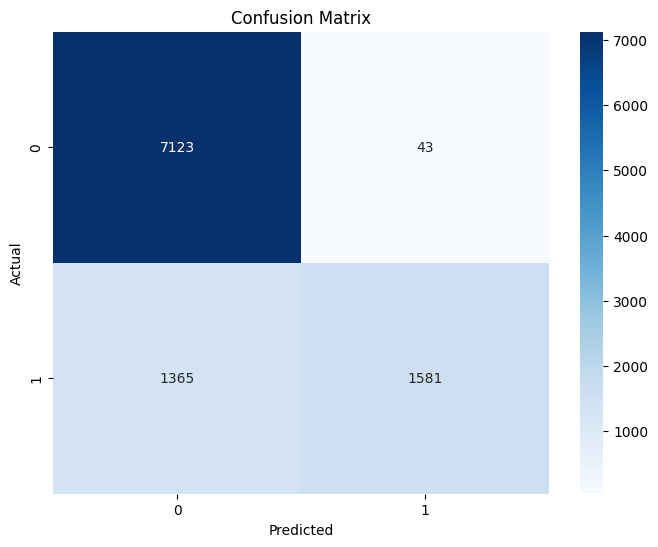

Linear Regression Classifier


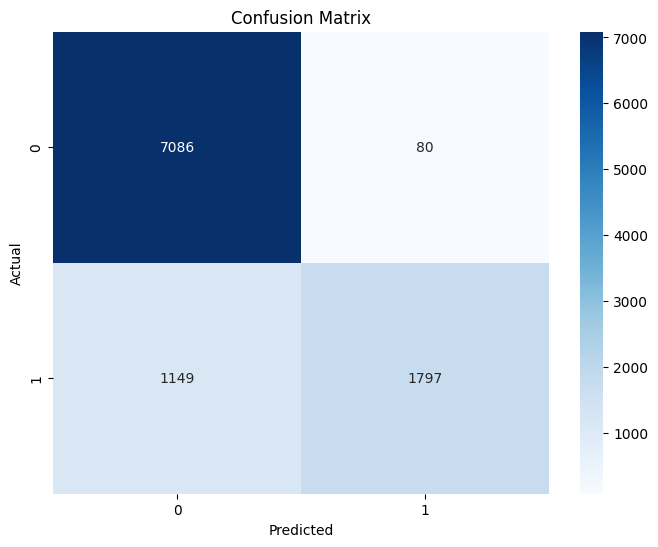

Logisitic Regression


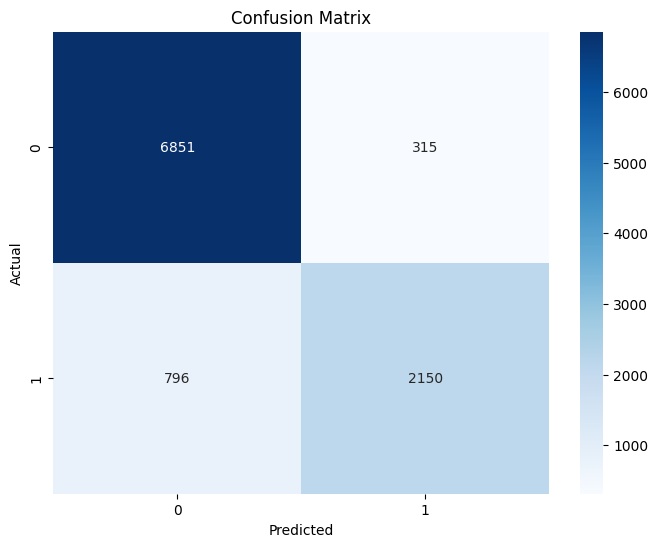

SVM


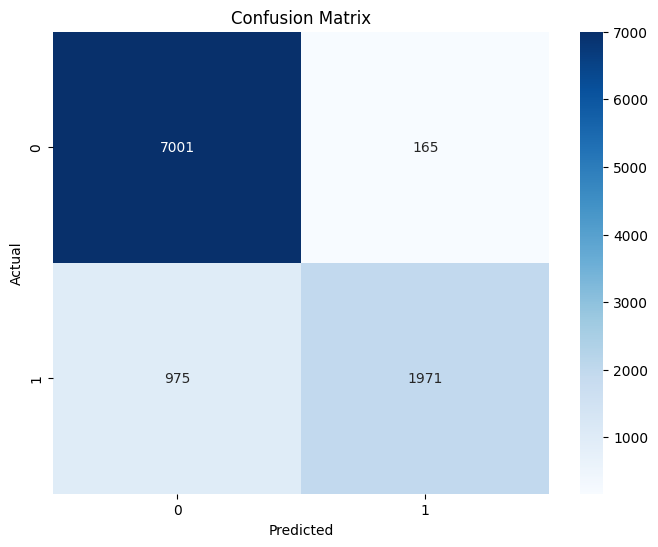

Random Forest


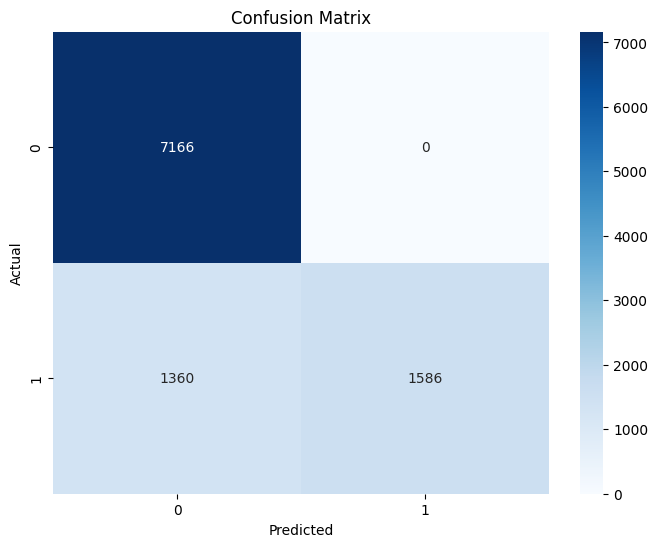

XGBoost


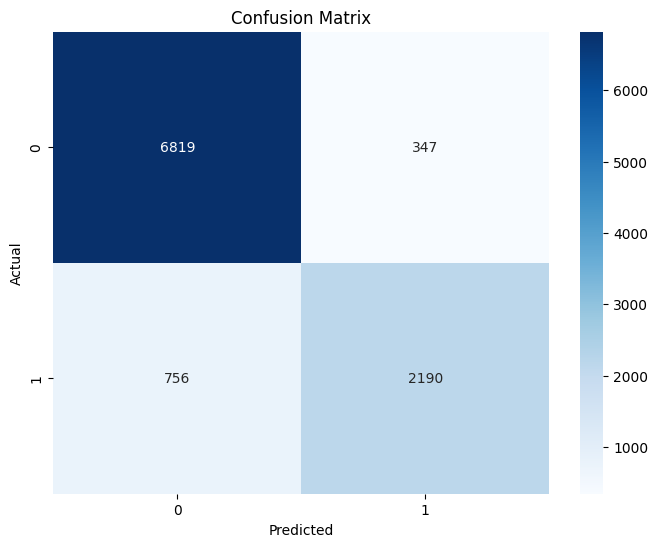

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import DataFrame
from pyspark.sql.functions import col

def plot_confusion_matrix(confusion_matrix: DataFrame, output_file: str):
    """
    Plots and saves a confusion matrix from a PySpark DataFrame.

    Args:
        confusion_matrix (DataFrame): Spark DataFrame containing columns `actual`, `prediction`, and `count`.
        output_file (str): File path to save the confusion matrix plot.
    """
    # Collect the confusion matrix data
    confusion_data = confusion_matrix.collect()

    # Extract unique labels
    labels = sorted(set([row["actual"] for row in confusion_data]))

    # Initialize confusion matrix
    matrix = [[0 for _ in labels] for _ in labels]

    # Populate the matrix
    for row in confusion_data:
        actual = int(row["actual"])
        predicted = int(row["prediction"])
        count = row["count"]
        matrix[actual][predicted] = count

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig(output_file, bbox_inches="tight")
    plt.show()
    plt.close()  # Close the plot to avoid overlapping

print("Naive Bayes")
plot_confusion_matrix(confusion_matrix_nb, "confusion_matrix_nb.png")
print("Linear Regression Classifier")
plot_confusion_matrix(confusion_matrix_linear_reg, "confusion_matrix_lin_reg.png")
print("Logisitic Regression")
plot_confusion_matrix(confusion_matrix_log_reg, "confusion_matrix_log_reg.png")
print("SVM")
plot_confusion_matrix(confusion_matrix_svm, "confusion_matrix_svm.png")
print("Random Forest")
plot_confusion_matrix(confusion_matrix_rf, "confusion_matrix_rf.png")
print("XGBoost")
plot_confusion_matrix(confusion_matrix_xgb, "confusion_matrix_xgb.png")


In [23]:
# Combine metrics into one dictionary
all_metrics = {
    "XGBoost": xgb_metrics,
    "Random Forest": rf_metrics,
    "Logistic Regression": metrics_log_reg,
    "Logistic Regression": metrics_log_reg,
    "SVM": svm_metrics,
    "Naive Bayes": nb_metrics
}

# Display metrics for all models
import pandas as pd

metrics_df = pd.DataFrame(all_metrics).T
metrics_df.index.name = "Model"
metrics_df.columns = ["Precision", "Recall", "Accuracy", "F1 Score"]

# Display the table
print(metrics_df)

                     Precision    Recall  Accuracy  F1 Score
Model                                                       
XGBoost               0.863224  0.743381  0.890922  0.798833
Random Forest         1.000000  0.538357  0.865506  0.699912
Logistic Regression   0.957379  0.609980  0.878461  0.745179
SVM                   0.922753  0.669043  0.887263  0.775679
Naive Bayes           0.973522  0.536660  0.860759  0.691904


## ROC-AUC Curve

Evaluating Logistic Regression...
Logistic Regression AUC: 0.9466229416689952


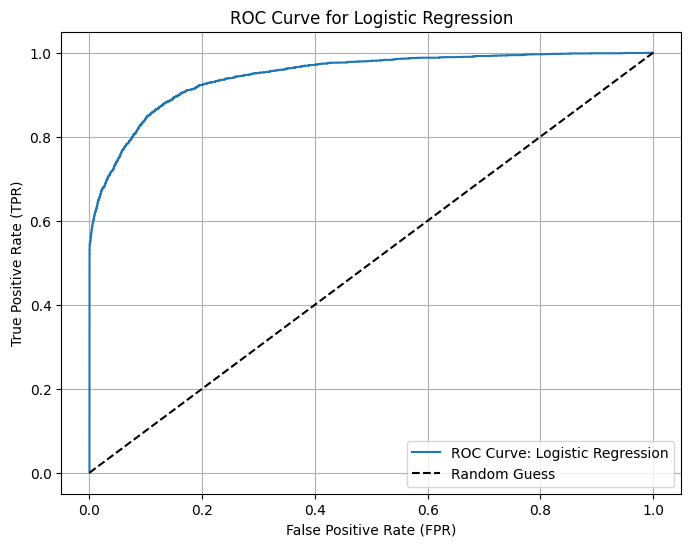

Evaluating Random Forest...
Random Forest AUC: 0.9326448261468555


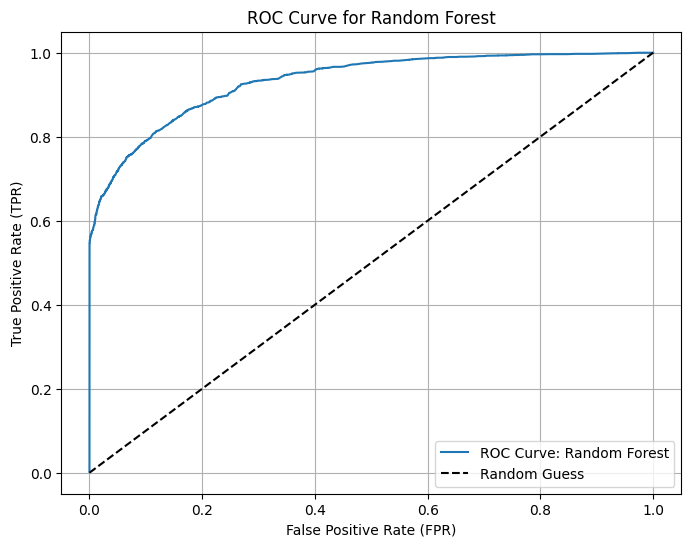

Evaluating SVM...
SVM AUC: 0.9433339036511533


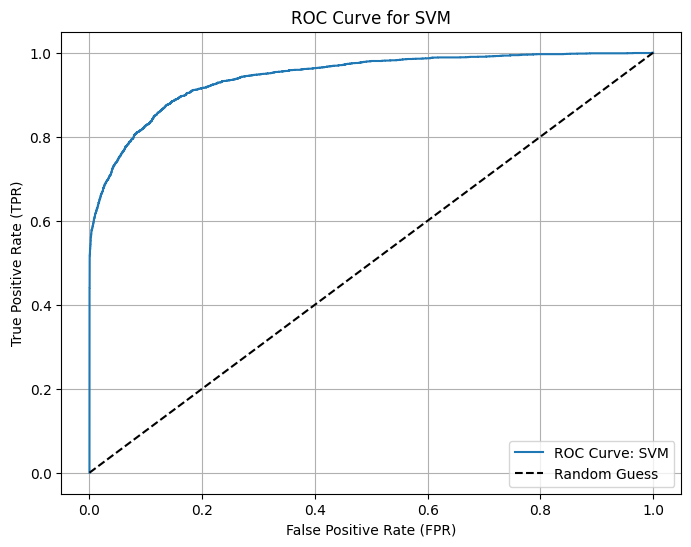

Evaluating XGBoost...
XGBoost AUC: 0.9453790661907835


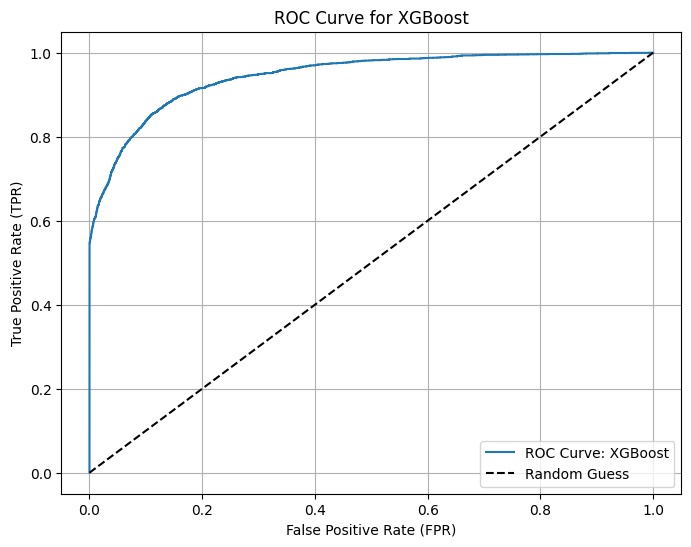

In [26]:
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import DenseVector

# Define a UDF to extract the probability for class 1 from rawPrediction
def extract_raw_probability(raw_pred):
    """
    Extract the probability of the positive class from rawPrediction for models without `probability` column.
    For binary classification, use the raw score for the positive class.
    """
    return float(raw_pred[1]) if isinstance(raw_pred, DenseVector) else raw_pred.values[1]

# UDF for extracting the positive class score
extract_raw_prob_udf = udf(lambda raw_pred: extract_raw_probability(raw_pred), DoubleType())

def plot_roc_curve(predictions, model_name):
    """
    Plot the ROC curve for a given model's predictions.

    Args:
        predictions (DataFrame): Spark DataFrame with `label`, `rawPrediction` columns.
        model_name (str): Name of the model for display in the plot.
    """
    # Add a column for positive class probabilities (from rawPrediction)
    predictions_with_prob = predictions.withColumn("positive_probability", extract_raw_prob_udf(col("rawPrediction")))

    # Convert to Pandas for ROC computation
    roc_pd = predictions_with_prob.select("positive_probability", "label").orderBy("positive_probability", ascending=False).toPandas()

    # Compute TPR and FPR
    thresholds = roc_pd["positive_probability"].unique()
    tpr = []  # True Positive Rate
    fpr = []  # False Positive Rate

    for threshold in thresholds:
        tp = ((roc_pd["positive_probability"] >= threshold) & (roc_pd["label"] == 1)).sum()
        fp = ((roc_pd["positive_probability"] >= threshold) & (roc_pd["label"] == 0)).sum()
        fn = ((roc_pd["positive_probability"] < threshold) & (roc_pd["label"] == 1)).sum()
        tn = ((roc_pd["positive_probability"] < threshold) & (roc_pd["label"] == 0)).sum()

        tpr.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
        fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve: {model_name}")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(f"ROC Curve for {model_name}")
    plt.legend()
    plt.grid()
    plt.savefig(f"ROC Curve for {model_name}")
    plt.show()

# Logistic Regression
print("Evaluating Logistic Regression...")
log_reg_predictions = best_log_reg_model.transform(test_data_scaled)  # Ensure best_log_reg_model is your tuned Logistic Regression model
log_reg_auc = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC").evaluate(log_reg_predictions)
print(f"Logistic Regression AUC: {log_reg_auc}")
plot_roc_curve(log_reg_predictions, "Logistic Regression")

# Random Forest
print("Evaluating Random Forest...")
rf_predictions = best_rf_model.transform(test_data_scaled)  # Ensure best_rf_model is your tuned Random Forest model
rf_auc = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC").evaluate(rf_predictions)
print(f"Random Forest AUC: {rf_auc}")
plot_roc_curve(rf_predictions, "Random Forest")

# SVM
print("Evaluating SVM...")
svm_predictions = best_svm_model.transform(test_data_scaled)  # Ensure best_svm_model is your tuned SVM model
svm_auc = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC").evaluate(svm_predictions)
print(f"SVM AUC: {svm_auc}")
plot_roc_curve(svm_predictions, "SVM")

# XGBoost
print("Evaluating XGBoost...")
xgb_predictions = best_xgb_model.transform(test_data_scaled)  # Ensure best_xgb_model is your tuned XGBoost model
xgb_auc = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC").evaluate(xgb_predictions)
print(f"XGBoost AUC: {xgb_auc}")
plot_roc_curve(xgb_predictions, "XGBoost")


## Feature Importance

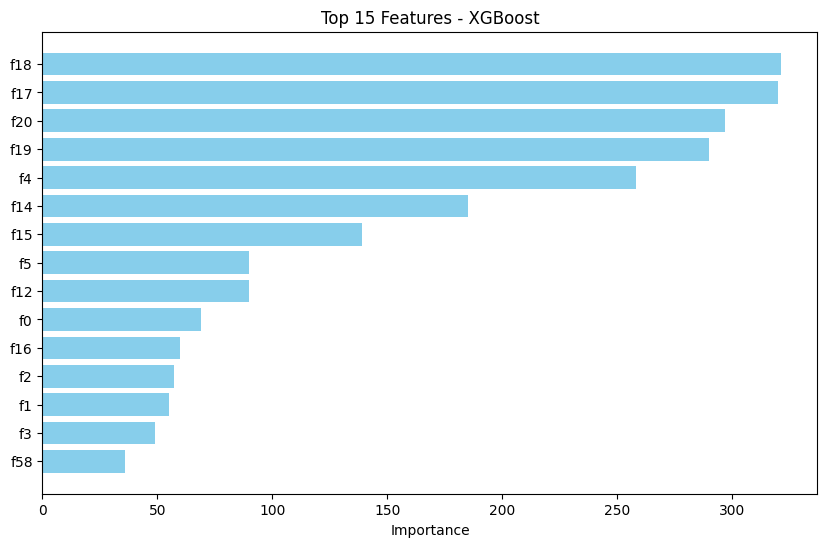

In [27]:
# Extract feature importances from the underlying XGBoost model
xgb_booster = best_xgb_model.get_booster()
xgb_importance = xgb_booster.get_score(importance_type='weight')

# Convert feature importances to a PySpark DataFrame
xgb_importance_df = spark.createDataFrame(
    [(feature, importance) for feature, importance in xgb_importance.items()],
    ["Feature", "Importance"]
)

# Sort and select the top 15 features
xgb_top_features = xgb_importance_df.orderBy(col("Importance").desc()).limit(15).collect()

# Prepare data for plotting
xgb_features = [row["Feature"] for row in xgb_top_features]
xgb_importances = [row["Importance"] for row in xgb_top_features]

# Plot the top 15 features
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(xgb_features[::-1], xgb_importances[::-1], color='skyblue')  # Reverse for better readability
plt.xlabel("Importance")
plt.title("Top 15 Features - XGBoost")
plt.show()


## Random Forest Accuracy with Num Trees

Training Random Forest with 1 trees...
Training Random Forest with 2 trees...
Training Random Forest with 3 trees...
Training Random Forest with 4 trees...
Training Random Forest with 5 trees...
Training Random Forest with 6 trees...
Training Random Forest with 7 trees...
Training Random Forest with 8 trees...
Training Random Forest with 9 trees...


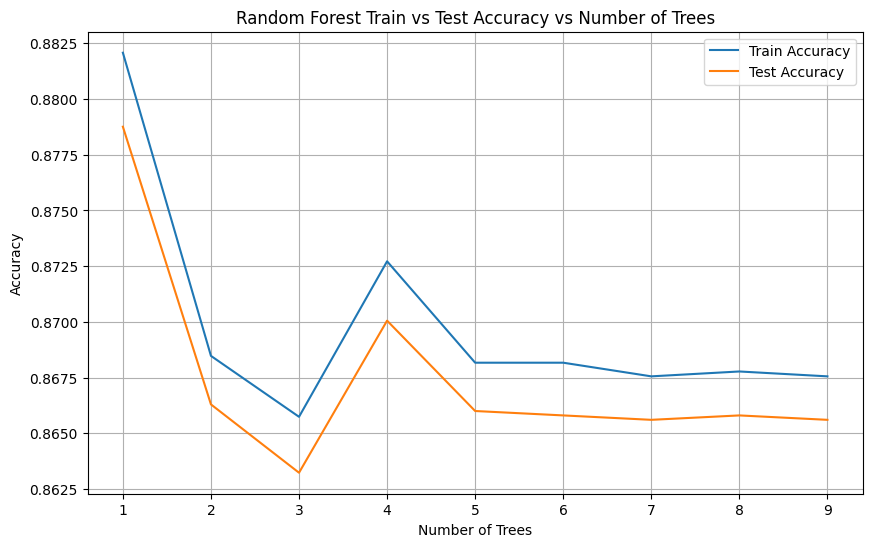

In [37]:
import matplotlib.pyplot as plt
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize variables to store results
num_trees_list = range(1, 10)
train_accuracies = []
test_accuracies = []

# Loop through different numbers of trees
for num_trees in num_trees_list:
    print(f"Training Random Forest with {num_trees} trees...")

    # Define Random Forest model
    rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=num_trees, seed=69, maxDepth=5, minInstancesPerNode=2)

    # Train the model
    rf_model = rf.fit(train_data_scaled)

    # Evaluate on training data
    train_predictions = rf_model.transform(train_data_scaled)
    train_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    train_accuracy = train_evaluator.evaluate(train_predictions)
    train_accuracies.append(train_accuracy)

    # Evaluate on testing data
    test_predictions = rf_model.transform(test_data_scaled)
    test_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    test_accuracy = test_evaluator.evaluate(test_predictions)
    test_accuracies.append(test_accuracy)

    # print(f"Train Accuracy with {num_trees} trees: {train_accuracy:.4f}")
    # print(f"Test Accuracy with {num_trees} trees: {test_accuracy:.4f}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(num_trees_list, train_accuracies, label="Train Accuracy")
plt.plot(num_trees_list, test_accuracies, label="Test Accuracy")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.title("Random Forest Train vs Test Accuracy vs Number of Trees")
plt.legend()
plt.grid()
plt.savefig("rf_train_test_accuracy_vs_num_trees.png", bbox_inches='tight')
plt.show()
